In [ ]:
# STEP 0: Setup
!pip install torch torchvision basicsr
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
!pip install -r requirements.txt
!python setup.py develop

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Patch Real-ESRGAN bug
!sed -i "/from torchvision.transforms.functional_tensor import rgb_to_grayscale/d" /usr/local/lib/python3.11/dist-packages/basicsr/data/degradations.py

# Copy Real-ESRGAN pretrained model to weights
!mkdir -p weights
!cp /content/drive/MyDrive/HyperIQA/RealESRGAN_x4plus.pth weights/


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  U

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image
from torchvision import transforms

# Define the HyperIQA model structure
class HyperIQA(nn.Module):
    def __init__(self):
        super(HyperIQA, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.fc1 = nn.Linear(2048, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze(1)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model and checkpoint
model = HyperIQA().to(device)
checkpoint_path = "/content/drive/MyDrive/HyperIQA/HyperIQA-resnet50-koniq10k-c96c41b1.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

# Update keys in the state dictionary to match your model
state_dict = checkpoint['params']
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith('base_model.'):
        new_state_dict[k.replace('base_model.', 'backbone.')] = v
    else:
        new_state_dict[k] = v

# Load the updated state dictionary with strict=False
model.load_state_dict(new_state_dict, strict=False)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


HyperIQA(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [ ]:
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def get_quality_score(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        score = (output.item() + 1) * 5  # Convert from [-1, 1] to [0, 10]

    return max(0, min(score, 10))  # Clamp for safety

# Example usage
image_path = "/content/drive/MyDrive/HyperIQA/IMG_20220626_205303.jpg"
quality_score = get_quality_score(image_path)
print(f"Predicted Image Quality Score: {quality_score:.2f}")


Predicted Image Quality Score: 4.92


In [ ]:
!pip install matplotlib pillow

In [ ]:
!git clone https://github.com/cszn/KAIR.git
%cd KAIR

Cloning into 'KAIR'...
remote: Enumerating objects: 1804, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 1804 (delta 13), reused 3 (delta 3), pack-reused 1786 (from 3)
Receiving objects: 100% (1804/1804), 19.41 MiB | 10.05 MiB/s, done.
Resolving deltas: 100% (1064/1064), done.
/content/Real-ESRGAN/KAIR


In [ ]:
!python main_download_pretrained_models.py --models "DnCNN" --model_dir "model_zoo"

trying to download ['DnCNN']
downloading [model_zoo/dncnn_15.pth] ...
done!
already exists, skip downloading [dncnn_25.pth]
downloading [model_zoo/dncnn_50.pth] ...
done!
downloading [model_zoo/dncnn3.pth] ...
done!
downloading [model_zoo/dncnn_color_blind.pth] ...
done!
downloading [model_zoo/dncnn_gray_blind.pth] ...
done!


In [ ]:
import torch.nn as nn

class DnCNN(nn.Module):
    def __init__(self, in_nc=3, out_nc=3, nc=64, nb=17, act_mode='BR'):
        super(DnCNN, self).__init__()
        layers = []
        layers.append(nn.Conv2d(in_nc, nc, 3, 1, 1, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for i in range(nb - 2):
            layers.append(nn.Conv2d(nc, nc, 3, 1, 1, bias=True))
            # Adding Batch Normalization layers
            layers.append(nn.BatchNorm2d(nc))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(nc, out_nc, 3, 1, 1, bias=True))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.model(x)
        return x - noise

# Load pretrained weights
dncnn_ckpt = torch.load('/content/Real-ESRGAN/KAIR/model_zoo/dncnn_15.pth', map_location=device)

# Create model
dncnn_model = DnCNN(in_nc=3, out_nc=3, nc=64, nb=17)

# Load state_dict, handling potential key mismatches
dncnn_state_dict = dncnn_model.state_dict()
for k, v in dncnn_ckpt.items():
    if k in dncnn_state_dict and dncnn_state_dict[k].shape == v.shape:
        dncnn_state_dict[k] = v

dncnn_model.load_state_dict(dncnn_state_dict, strict=False)  # Load with strict=False

dncnn_model.to(device)
dncnn_model.eval()

DnCNN(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2

In [ ]:
from torchvision import transforms
from PIL import Image

original_img_path = "/content/drive/MyDrive/HyperIQA/IMG_20220626_205303.jpg"

img = Image.open(original_img_path).convert("RGB")
denoise_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
img_tensor = denoise_transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    denoised_tensor = dncnn_model(img_tensor)

# De-normalize and save
denoised_tensor = denoised_tensor.squeeze().cpu().clamp(-1, 1) * 0.5 + 0.5
denoised_img = transforms.ToPILImage()(denoised_tensor)
denoised_img_path = "/content/drive/MyDrive/HyperIQA/denoised/img_20_denoised.JPG"
denoised_img.save(denoised_img_path)


In [ ]:
!cp /content/drive/MyDrive/HyperIQA/RealESRGAN_x4plus.pth /content/Real-ESRGAN/weights

In [ ]:
!python3 /content/Real-ESRGAN/inference_realesrgan.py \
-n RealESRGAN_x4plus \
-i "/content/drive/MyDrive/HyperIQA/denoised/img_20_denoised.JPG" \
-s 4 \
--tile 256 --tile_pad 10 \
-o "/content/drive/MyDrive/HyperIQA/output"


Testing 0 img_20_denoised
	Tile 1/9
	Tile 2/9
	Tile 3/9
	Tile 4/9
	Tile 5/9
	Tile 6/9
	Tile 7/9
	Tile 8/9
	Tile 9/9


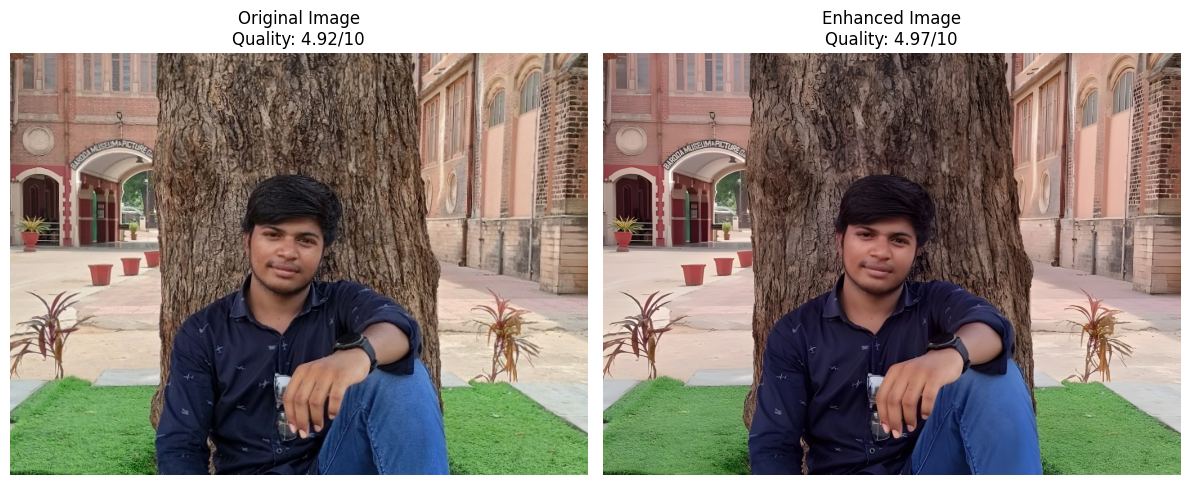

In [ ]:
import matplotlib.pyplot as plt

original_img_path = '/content/drive/MyDrive/HyperIQA/IMG_20220626_205303.jpg'  # your input image
enhanced_img_path = '/content/drive/MyDrive/HyperIQA/output/img_20_denoised_out.JPG'  # your output after DnCNN + Real-ESRGAN

# Get scores
original_score = get_quality_score(original_img_path)
enhanced_score = get_quality_score(enhanced_img_path)

# Load images
original_img = Image.open(original_img_path).convert('RGB')
enhanced_img = Image.open(enhanced_img_path).convert('RGB')

# Plot side-by-side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title(f"Original Image\nQuality: {original_score:.2f}/10")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced_img)
plt.title(f"Enhanced Image\nQuality: {enhanced_score:.2f}/10")
plt.axis('off')
plt.tight_layout()
plt.show()
